# ECG-Pytorch-Ver2.0

@create 2021-09-13
@author 孙寒石
@env Pytorch 1.9.0 Python 3.7

## Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
    
X=np.array(X)
y=np.array(y)
X = standardization(X)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


In [3]:
batch_size = 16
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] # 取第0元素：长度
        self.x_train = torch.from_numpy(X_train).float().to("cuda")
        self.y_train = torch.from_numpy(y_train).long().to("cuda")
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] # 返回对应样本即可
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] # 取第0元素：长度
        self.x_test = torch.from_numpy(X_test).float().to("cuda")
        self.y_test = torch.from_numpy(y_test).long().to("cuda")
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] # 返回对应样本即可
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Design Model

In [4]:
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,8,16,stride=2,padding=7),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8,stride=4),
   
            nn.Conv1d(8,12,12,padding=5,stride=2),
            nn.ReLU(),
            #nn.BatchNorm1d(16),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(12,32,9,stride=1,padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5,stride=2),
            
            nn.Conv1d(32,64,7,stride=1,padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(64,64,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,72,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            Flatten(),
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to(device)
from torchsummary import summary
summary(model, input_size=(1, 3600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 1800]             136
              ReLU-2              [-1, 8, 1800]               0
         MaxPool1d-3               [-1, 8, 449]               0
            Conv1d-4              [-1, 12, 224]           1,164
              ReLU-5              [-1, 12, 224]               0
         MaxPool1d-6              [-1, 12, 111]               0
            Conv1d-7              [-1, 32, 111]           3,488
              ReLU-8              [-1, 32, 111]               0
         MaxPool1d-9               [-1, 32, 54]               0
           Conv1d-10               [-1, 64, 54]          14,400
             ReLU-11               [-1, 64, 54]               0
        MaxPool1d-12               [-1, 64, 26]               0
           Conv1d-13               [-1, 64, 26]          20,544
             ReLU-14               [-1,

/home/preminstrel/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
print(model)

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(2,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 12, kernel_size=(12,), stride=(2,), padding=(5,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(12, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(

## Construct Loss and Optimizer

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.0, amsgrad = False)

## Train

In [7]:
correct_list = []
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print('[%d, %5d] loss: %.8f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    correct_list.append(100 * correct / total)
    print('Accuracy on test set: %.8f %%' % (100 * correct / total))
    
    
for epoch in range(300):
    train(epoch)
    test()

[1,    10] loss: 0.09508510
[1,    20] loss: 0.09474423
[1,    30] loss: 0.09416510
[1,    40] loss: 0.09162017
[1,    50] loss: 0.08004860
Accuracy on test set: 28.50000000 %
[2,    10] loss: 0.08331942
[2,    20] loss: 0.08021543
[2,    30] loss: 0.08177697
[2,    40] loss: 0.07562988
[2,    50] loss: 0.08450631
Accuracy on test set: 28.00000000 %
[3,    10] loss: 0.08173744
[3,    20] loss: 0.07952932
[3,    30] loss: 0.07507594
[3,    40] loss: 0.07783345
[3,    50] loss: 0.07736654
Accuracy on test set: 28.00000000 %
[4,    10] loss: 0.07768884
[4,    20] loss: 0.07715657
[4,    30] loss: 0.07866971
[4,    40] loss: 0.07649833
[4,    50] loss: 0.07376126
Accuracy on test set: 28.50000000 %
[5,    10] loss: 0.07578515
[5,    20] loss: 0.07477365
[5,    30] loss: 0.07689286
[5,    40] loss: 0.07466269
[5,    50] loss: 0.07685772
Accuracy on test set: 28.50000000 %
[6,    10] loss: 0.07478001
[6,    20] loss: 0.07576138
[6,    30] loss: 0.07534405
[6,    40] loss: 0.07566824
[6,    5

[47,    10] loss: 0.00879948
[47,    20] loss: 0.00888296
[47,    30] loss: 0.00728868
[47,    40] loss: 0.00945656
[47,    50] loss: 0.01141154
Accuracy on test set: 89.00000000 %
[48,    10] loss: 0.00981666
[48,    20] loss: 0.00730250
[48,    30] loss: 0.00877964
[48,    40] loss: 0.01175526
[48,    50] loss: 0.00772555
Accuracy on test set: 84.50000000 %
[49,    10] loss: 0.00856631
[49,    20] loss: 0.00841340
[49,    30] loss: 0.00938434
[49,    40] loss: 0.01015243
[49,    50] loss: 0.00817311
Accuracy on test set: 88.50000000 %
[50,    10] loss: 0.00834406
[50,    20] loss: 0.00701532
[50,    30] loss: 0.00680829
[50,    40] loss: 0.00833003
[50,    50] loss: 0.01040963
Accuracy on test set: 88.00000000 %
[51,    10] loss: 0.00762956
[51,    20] loss: 0.00652113
[51,    30] loss: 0.00837040
[51,    40] loss: 0.00861836
[51,    50] loss: 0.00981468
Accuracy on test set: 85.00000000 %
[52,    10] loss: 0.00983685
[52,    20] loss: 0.00828201
[52,    30] loss: 0.00684604
[52,    

[92,    30] loss: 0.00332052
[92,    40] loss: 0.00219788
[92,    50] loss: 0.00198954
Accuracy on test set: 90.50000000 %
[93,    10] loss: 0.00270415
[93,    20] loss: 0.00165108
[93,    30] loss: 0.00201942
[93,    40] loss: 0.00097133
[93,    50] loss: 0.00084875
Accuracy on test set: 89.50000000 %
[94,    10] loss: 0.00198540
[94,    20] loss: 0.00128889
[94,    30] loss: 0.00235540
[94,    40] loss: 0.00073037
[94,    50] loss: 0.00153414
Accuracy on test set: 89.50000000 %
[95,    10] loss: 0.00124433
[95,    20] loss: 0.00103468
[95,    30] loss: 0.00348447
[95,    40] loss: 0.00277933
[95,    50] loss: 0.00201320
Accuracy on test set: 86.00000000 %
[96,    10] loss: 0.00568140
[96,    20] loss: 0.00369210
[96,    30] loss: 0.00690483
[96,    40] loss: 0.00267136
[96,    50] loss: 0.00505471
Accuracy on test set: 89.50000000 %
[97,    10] loss: 0.00295317
[97,    20] loss: 0.00570832
[97,    30] loss: 0.00363456
[97,    40] loss: 0.00292545
[97,    50] loss: 0.00827864
Accuracy

[136,    50] loss: 0.00242518
Accuracy on test set: 88.00000000 %
[137,    10] loss: 0.00121824
[137,    20] loss: 0.00066913
[137,    30] loss: 0.00088960
[137,    40] loss: 0.00071000
[137,    50] loss: 0.00097121
Accuracy on test set: 91.00000000 %
[138,    10] loss: 0.00033593
[138,    20] loss: 0.00090165
[138,    30] loss: 0.00095338
[138,    40] loss: 0.00115404
[138,    50] loss: 0.00027336
Accuracy on test set: 86.00000000 %
[139,    10] loss: 0.00046197
[139,    20] loss: 0.00065054
[139,    30] loss: 0.00035795
[139,    40] loss: 0.00015101
[139,    50] loss: 0.00032771
Accuracy on test set: 91.50000000 %
[140,    10] loss: 0.00033831
[140,    20] loss: 0.00020907
[140,    30] loss: 0.00015996
[140,    40] loss: 0.00031244
[140,    50] loss: 0.00027745
Accuracy on test set: 90.00000000 %
[141,    10] loss: 0.00011227
[141,    20] loss: 0.00027393
[141,    30] loss: 0.00048129
[141,    40] loss: 0.00025750
[141,    50] loss: 0.00013443
Accuracy on test set: 90.50000000 %
[142

[181,    10] loss: 0.00045782
[181,    20] loss: 0.00089436
[181,    30] loss: 0.00078124
[181,    40] loss: 0.00049540
[181,    50] loss: 0.00045170
Accuracy on test set: 90.50000000 %
[182,    10] loss: 0.00038302
[182,    20] loss: 0.00032378
[182,    30] loss: 0.00050710
[182,    40] loss: 0.00060235
[182,    50] loss: 0.00054098
Accuracy on test set: 87.00000000 %
[183,    10] loss: 0.00033468
[183,    20] loss: 0.00013877
[183,    30] loss: 0.00042595
[183,    40] loss: 0.00016340
[183,    50] loss: 0.00027446
Accuracy on test set: 88.00000000 %
[184,    10] loss: 0.00015976
[184,    20] loss: 0.00013987
[184,    30] loss: 0.00030466
[184,    40] loss: 0.00021803
[184,    50] loss: 0.00027867
Accuracy on test set: 87.50000000 %
[185,    10] loss: 0.00014911
[185,    20] loss: 0.00010341
[185,    30] loss: 0.00011390
[185,    40] loss: 0.00012708
[185,    50] loss: 0.00019313
Accuracy on test set: 88.00000000 %
[186,    10] loss: 0.00020555
[186,    20] loss: 0.00015197
[186,    3

[225,    30] loss: 0.00026655
[225,    40] loss: 0.00022260
[225,    50] loss: 0.00041299
Accuracy on test set: 92.00000000 %
[226,    10] loss: 0.00025452
[226,    20] loss: 0.00008991
[226,    30] loss: 0.00016014
[226,    40] loss: 0.00014915
[226,    50] loss: 0.00020054
Accuracy on test set: 90.50000000 %
[227,    10] loss: 0.00037116
[227,    20] loss: 0.00012623
[227,    30] loss: 0.00014549
[227,    40] loss: 0.00006089
[227,    50] loss: 0.00009497
Accuracy on test set: 89.00000000 %
[228,    10] loss: 0.00006998
[228,    20] loss: 0.00004092
[228,    30] loss: 0.00006616
[228,    40] loss: 0.00014823
[228,    50] loss: 0.00009185
Accuracy on test set: 90.00000000 %
[229,    10] loss: 0.00004642
[229,    20] loss: 0.00010747
[229,    30] loss: 0.00016131
[229,    40] loss: 0.00002824
[229,    50] loss: 0.00006230
Accuracy on test set: 88.50000000 %
[230,    10] loss: 0.00005127
[230,    20] loss: 0.00011954
[230,    30] loss: 0.00004578
[230,    40] loss: 0.00023944
[230,    5

[269,    40] loss: 0.00340197
[269,    50] loss: 0.00428952
Accuracy on test set: 83.50000000 %
[270,    10] loss: 0.00481407
[270,    20] loss: 0.00205989
[270,    30] loss: 0.00319173
[270,    40] loss: 0.00165893
[270,    50] loss: 0.00112884
Accuracy on test set: 89.00000000 %
[271,    10] loss: 0.00093822
[271,    20] loss: 0.00040016
[271,    30] loss: 0.00092335
[271,    40] loss: 0.00043798
[271,    50] loss: 0.00052817
Accuracy on test set: 88.50000000 %
[272,    10] loss: 0.00021481
[272,    20] loss: 0.00027870
[272,    30] loss: 0.00007016
[272,    40] loss: 0.00037496
[272,    50] loss: 0.00115817
Accuracy on test set: 88.50000000 %
[273,    10] loss: 0.00040645
[273,    20] loss: 0.00020245
[273,    30] loss: 0.00010088
[273,    40] loss: 0.00014282
[273,    50] loss: 0.00073750
Accuracy on test set: 89.00000000 %
[274,    10] loss: 0.00002997
[274,    20] loss: 0.00030209
[274,    30] loss: 0.00021794
[274,    40] loss: 0.00017909
[274,    50] loss: 0.00009928
Accuracy o

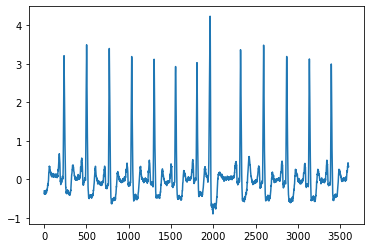

In [14]:
t=np.arange(3600)
p = X_train[1,:,:].reshape((3600))
plt.plot(t,p)

In [15]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([ 6,  6,  2,  0,  0, 13, 13, 13,  7,  0,  0,  3,  6,  0,  0,  0],
       device='cuda:0')
tensor([ 6,  6,  3,  0,  0, 13, 13, 13,  7,  0,  0,  3,  6,  0,  1,  0],
       device='cuda:0')
tensor([14,  3,  7,  3, 13,  1,  3,  5,  5,  6, 16,  0,  6, 13, 13, 14],
       device='cuda:0')
tensor([14,  3,  7,  3, 13,  1,  3,  5,  5, 12, 16,  0,  7, 13, 13, 14],
       device='cuda:0')
tensor([ 3,  1,  0, 14,  6,  1, 13,  0,  0,  0, 13,  0,  1,  6,  4,  6],
       device='cuda:0')
tensor([ 3,  1,  0, 14,  6,  1,  1,  6,  0,  0, 13,  0,  0,  8,  2,  6],
       device='cuda:0')
tensor([ 0,  6,  0, 13,  3,  1,  0,  0,  0,  6, 14, 13,  0,  3,  1, 16],
       device='cuda:0')
tensor([ 0,  8,  0, 13,  0,  0,  0,  0,  0,  6, 14, 13,  1,  3,  1, 16],
       device='cuda:0')
tensor([ 0,  6,  3,  0,  2,  0, 13,  3,  0,  6,  0,  6,  3, 13,  6, 14],
       device='cuda:0')
tensor([ 0,  6,  3,  0, 13,  0, 13,  3,  0,  6,  0,  6,  3, 13,  6, 14],
       device='cuda:0')
tensor([ 3,  3,  1,  6,  1,  0

Text(0, 0.5, 'Accuracy(%)')

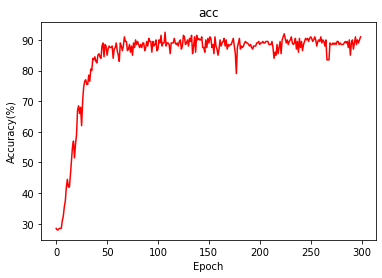

In [16]:
plt.rcParams['axes.grid'] = False
plt.plot(correct_list,'r')
plt.title('acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')

In [17]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
conf_matrix = torch.zeros(17, 17)

In [19]:
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        out = model(images)
        prediction = torch.max(out, 1)[1]
        conf_matrix = confusion_matrix(prediction, labels=labels, conf_matrix=conf_matrix)

/home/preminstrel/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Normalized confusion matrix
[[0.9137931  0.03448276 0.         0.         0.         0.
  0.03448276 0.         0.         0.         0.         0.
  0.         0.01724138 0.         0.         0.        ]
 [0.23076923 0.61538462 0.         0.         0.         0.
  0.07692308 0.         0.         0.         0.         0.
  0.         0.         0.07692308 0.         0.        ]
 [0.         0.         0.33333333 0.33333333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.33333333 0.         0.         0.        ]
 [0.03333333 0.         0.         0.96666667 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.5        0.         0.5        0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.14285714 0.         0.         0.         0.85714286
  0.         0

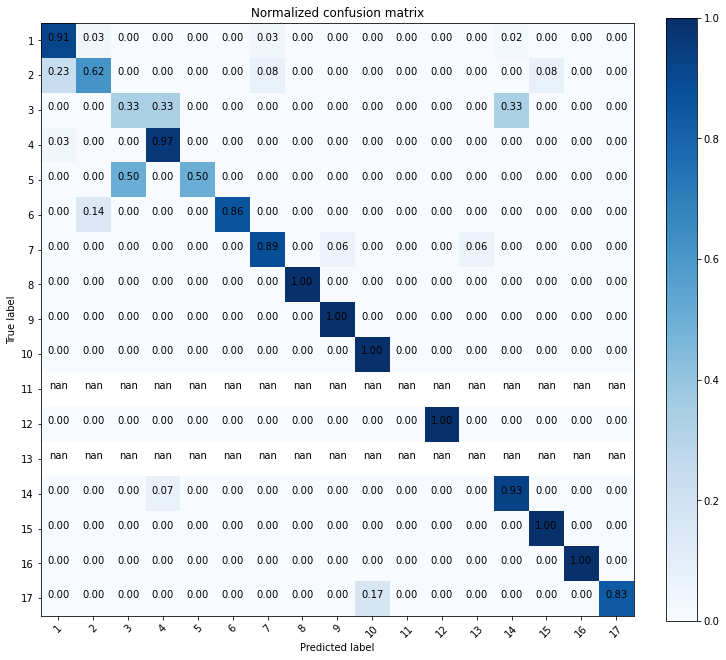

In [20]:
attack_types=['1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix.numpy(), classes=attack_types, normalize=True, title='Normalized confusion matrix')

## Param Picture

In [22]:
#model = arrhythmia_classifier()
#model.load_state_dict(torch.load('acc91.pt'))
model.state_dict().keys()

odict_keys(['cnn.0.weight', 'cnn.0.bias', 'cnn.3.weight', 'cnn.3.bias', 'cnn.6.weight', 'cnn.6.bias', 'cnn.9.weight', 'cnn.9.bias', 'cnn.12.weight', 'cnn.12.bias', 'cnn.15.weight', 'cnn.15.bias', 'cnn.18.weight', 'cnn.18.bias', 'cnn.22.weight', 'cnn.22.bias', 'cnn.25.weight', 'cnn.25.bias'])

In [49]:
model.cnn[0].weight.view((8,16))

tensor([[ 0.0363, -0.3086,  0.0963, -0.3000, -0.2941,  0.0386, -0.2418, -0.1265,
          0.1060, -0.0927, -0.2988,  0.0939, -0.0858, -0.1390,  0.1031,  0.1393],
        [-0.1673, -0.1148, -0.2023,  0.1720,  0.2564,  0.1689,  0.0544,  0.2043,
          0.0639,  0.1506,  0.1471, -0.1435,  0.1832, -0.0943,  0.0537, -0.0079],
        [ 0.1410, -0.0823,  0.1510, -0.1120, -0.1129, -0.2404, -0.2609,  0.1046,
          0.0594, -0.2569, -0.1306, -0.2652, -0.0572, -0.3144, -0.2816,  0.0877],
        [ 0.1330, -0.2077,  0.1332, -0.1502, -0.0350,  0.1753, -0.2297, -0.1226,
         -0.0977, -0.1517,  0.0811, -0.2592, -0.1002,  0.1902,  0.1446, -0.2227],
        [-0.2982, -0.1177, -0.1983, -0.2501,  0.0366,  0.0815, -0.2964, -0.0647,
         -0.1328, -0.0546, -0.1890,  0.0961, -0.0345,  0.1162,  0.2039,  0.0160],
        [ 0.1202,  0.2426,  0.1259,  0.2306,  0.1911,  0.2384,  0.1471, -0.1207,
          0.1145,  0.0266, -0.1306, -0.1726,  0.2215, -0.0263, -0.1072,  0.2036],
        [ 0.0099,  0.0

In [59]:
first_layer = model.cnn[0].weight.view((8,16)).to("cpu").detach().numpy()

In [60]:
first_layer[0]

array([ 0.03632697, -0.30860347,  0.09633865, -0.30003494, -0.294129  ,
        0.03856242, -0.24175955, -0.1265449 ,  0.10595261, -0.09269666,
       -0.29875827,  0.09392476, -0.08577517, -0.13904147,  0.10310577,
        0.13928461], dtype=float32)

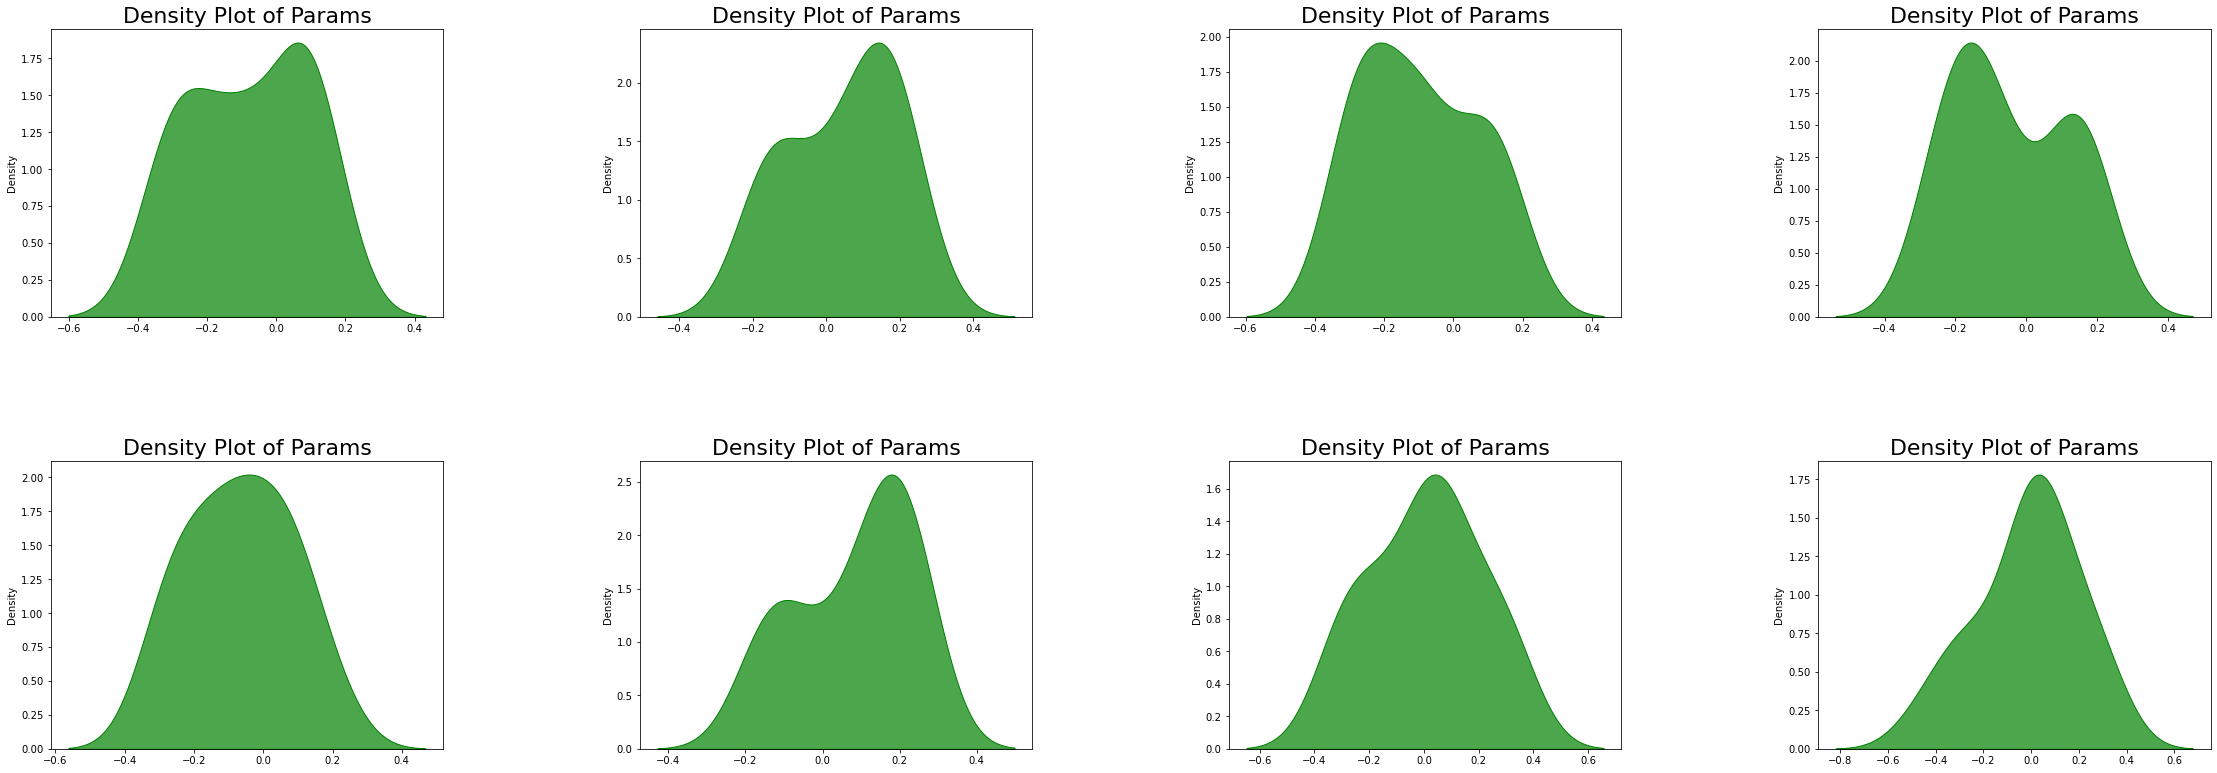

In [80]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# 密度图

# Draw Plot
#plt.subplot(2, 2, 1)
#plt.figure(figsize=(10,6), dpi= 80)
#sns.kdeplot(first_layer[0], shade=True, color="g", alpha=.7)
plt.subplots_adjust(left=0, bottom=0, right=5, top=2.5,
                wspace=0.5, hspace=0.5)
for i in range(8):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(first_layer[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

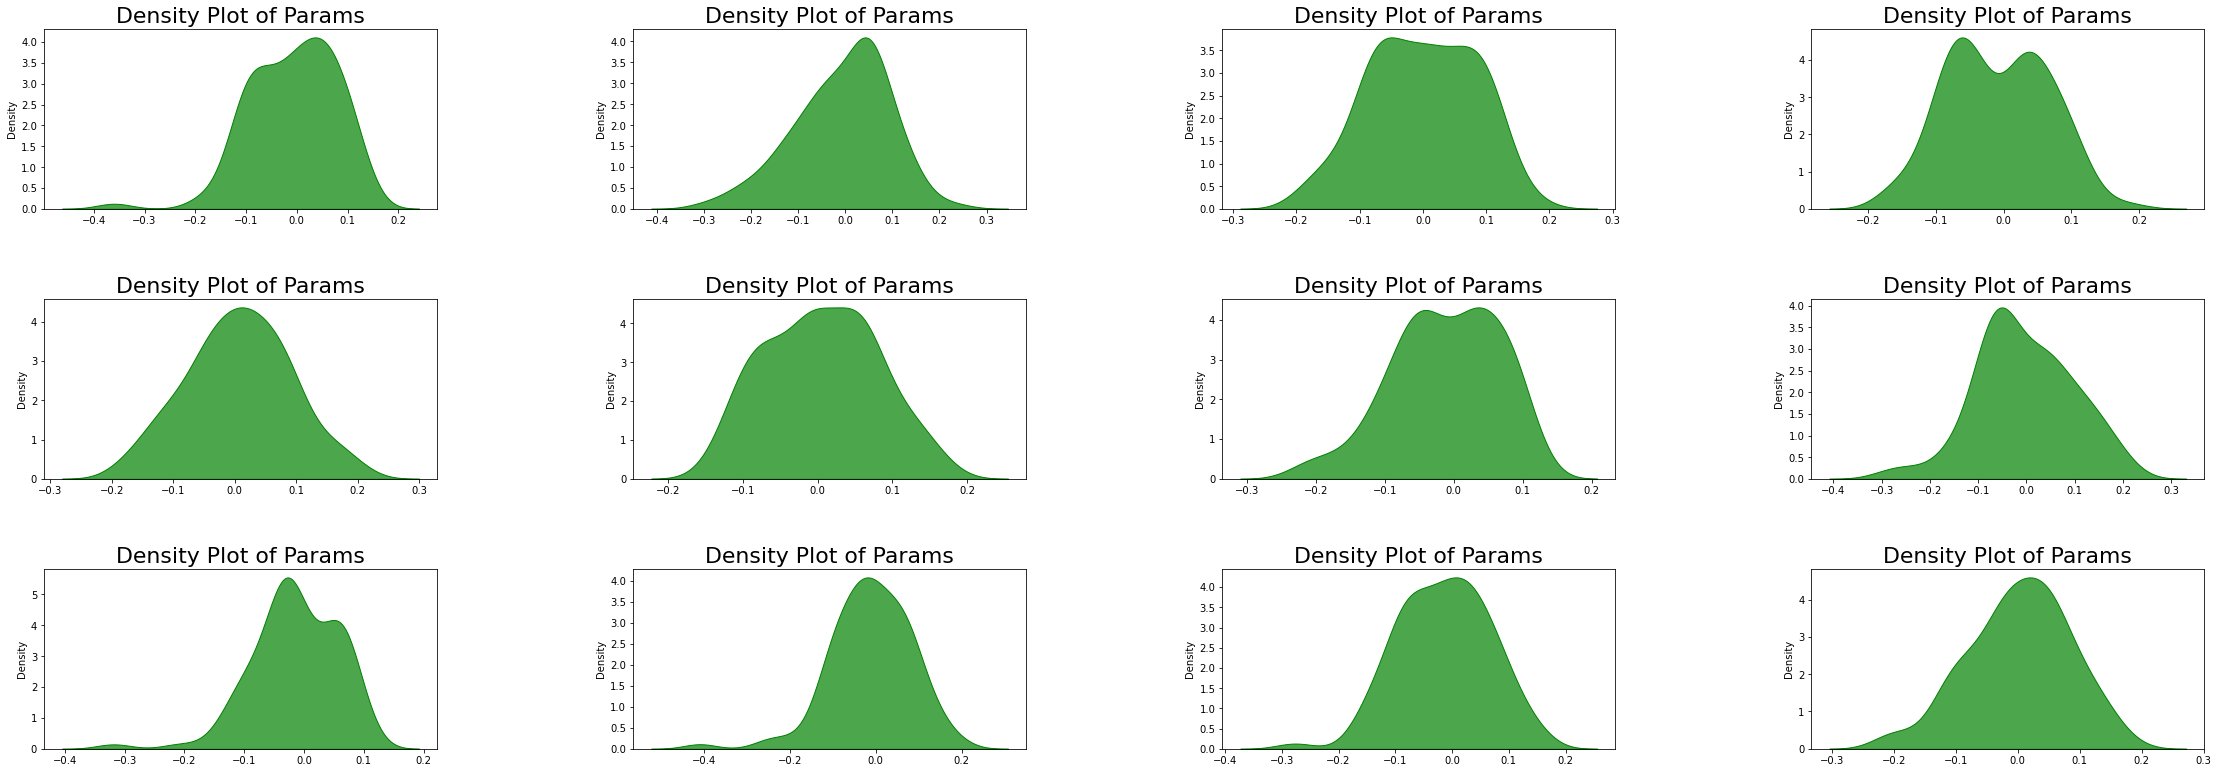

In [89]:
layer2 = model.cnn[3].weight.view((12,12*8)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=2.5,
                wspace=0.5, hspace=0.5)
for i in range(12):
    plt.subplot(3, 4, i+1)
    sns.kdeplot(layer2[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

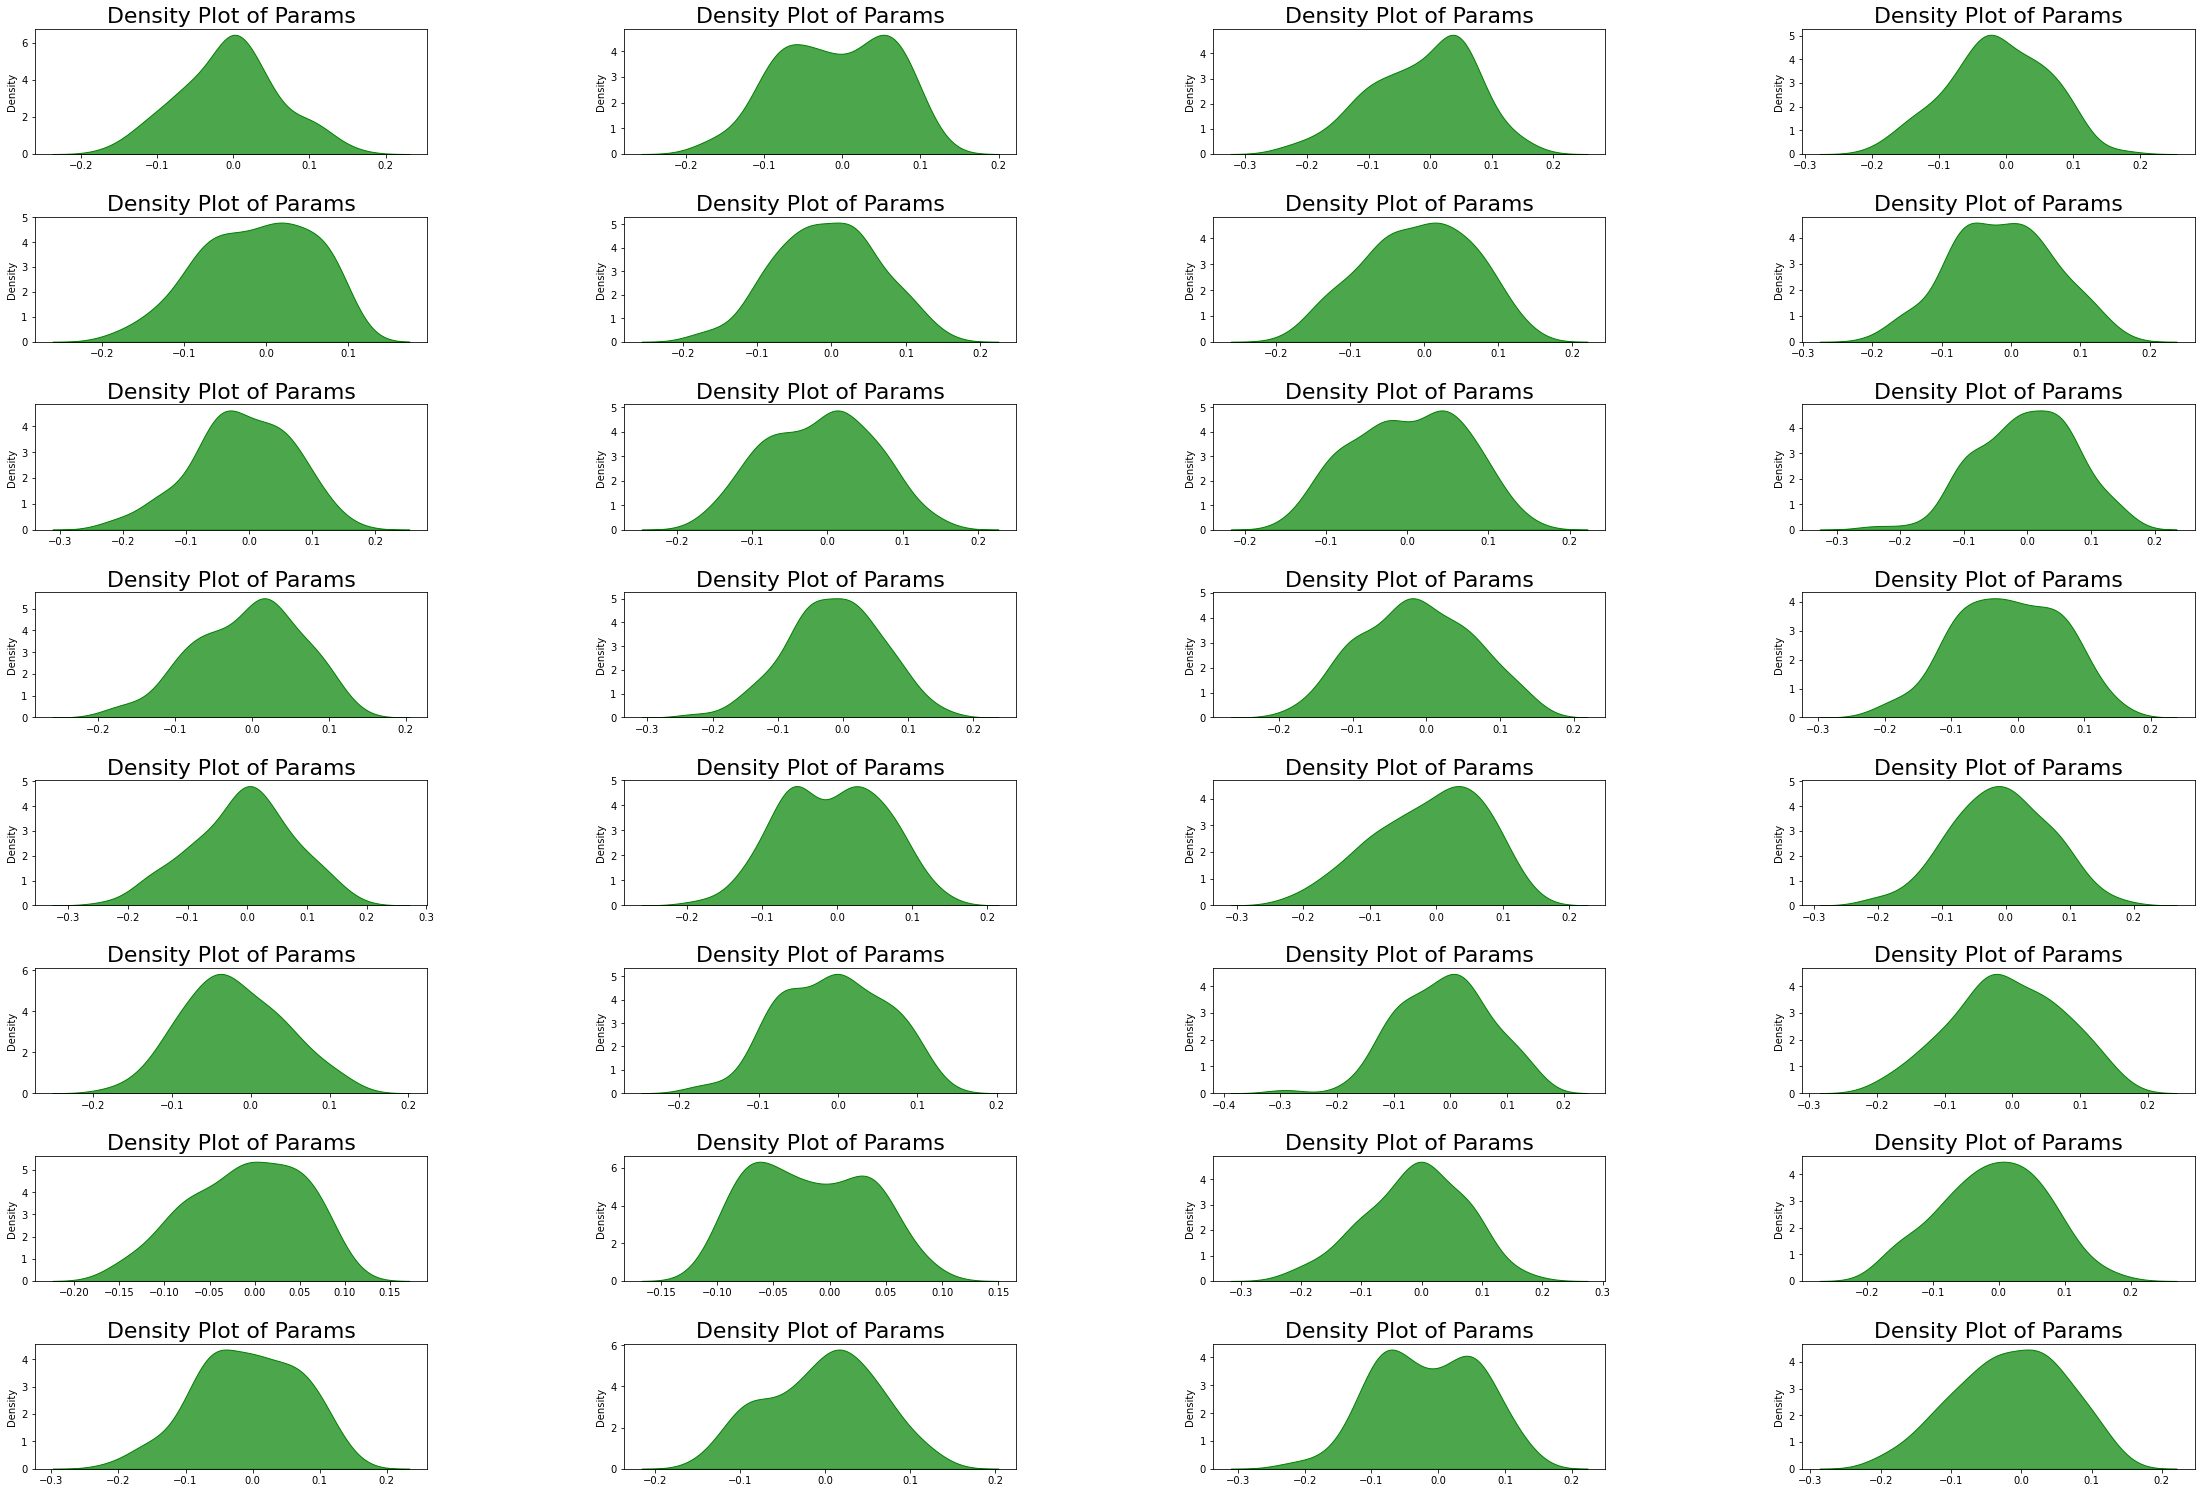

In [94]:
layer3 = model.cnn[6].weight.view((32,12*9)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(32):
    plt.subplot(8, 4, i+1)
    sns.kdeplot(layer3[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

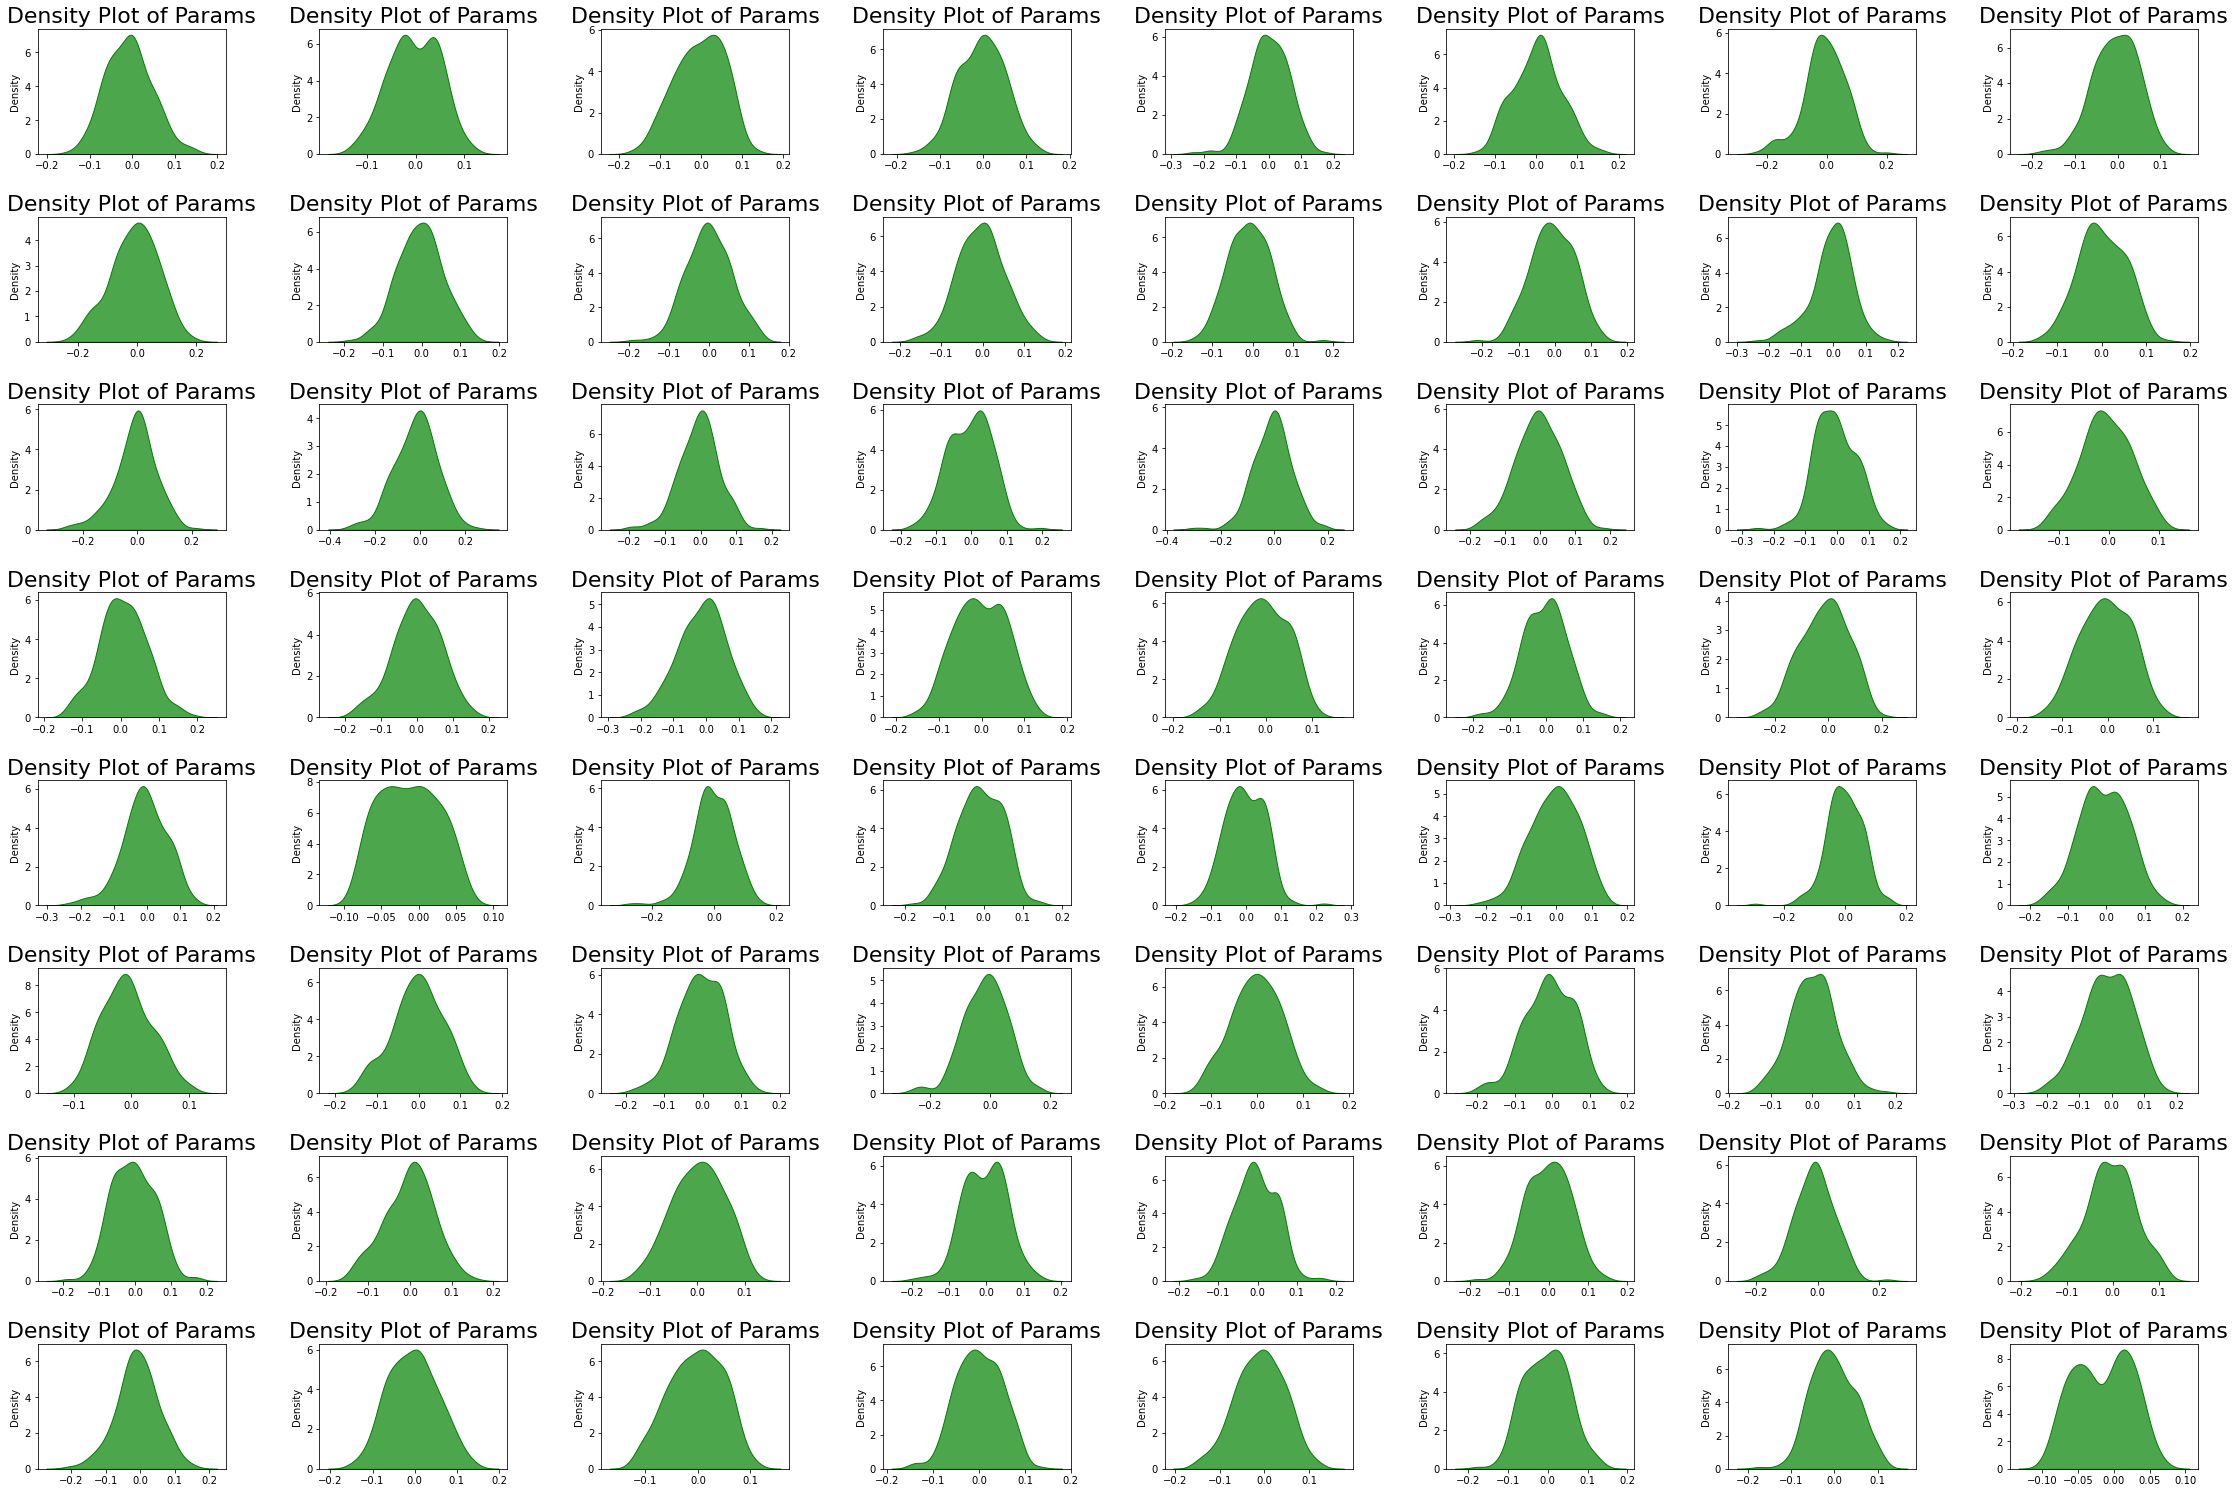

In [95]:
layer4 = model.cnn[9].weight.view((64,32*7)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(64):
    plt.subplot(8, 8, i+1)
    sns.kdeplot(layer4[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

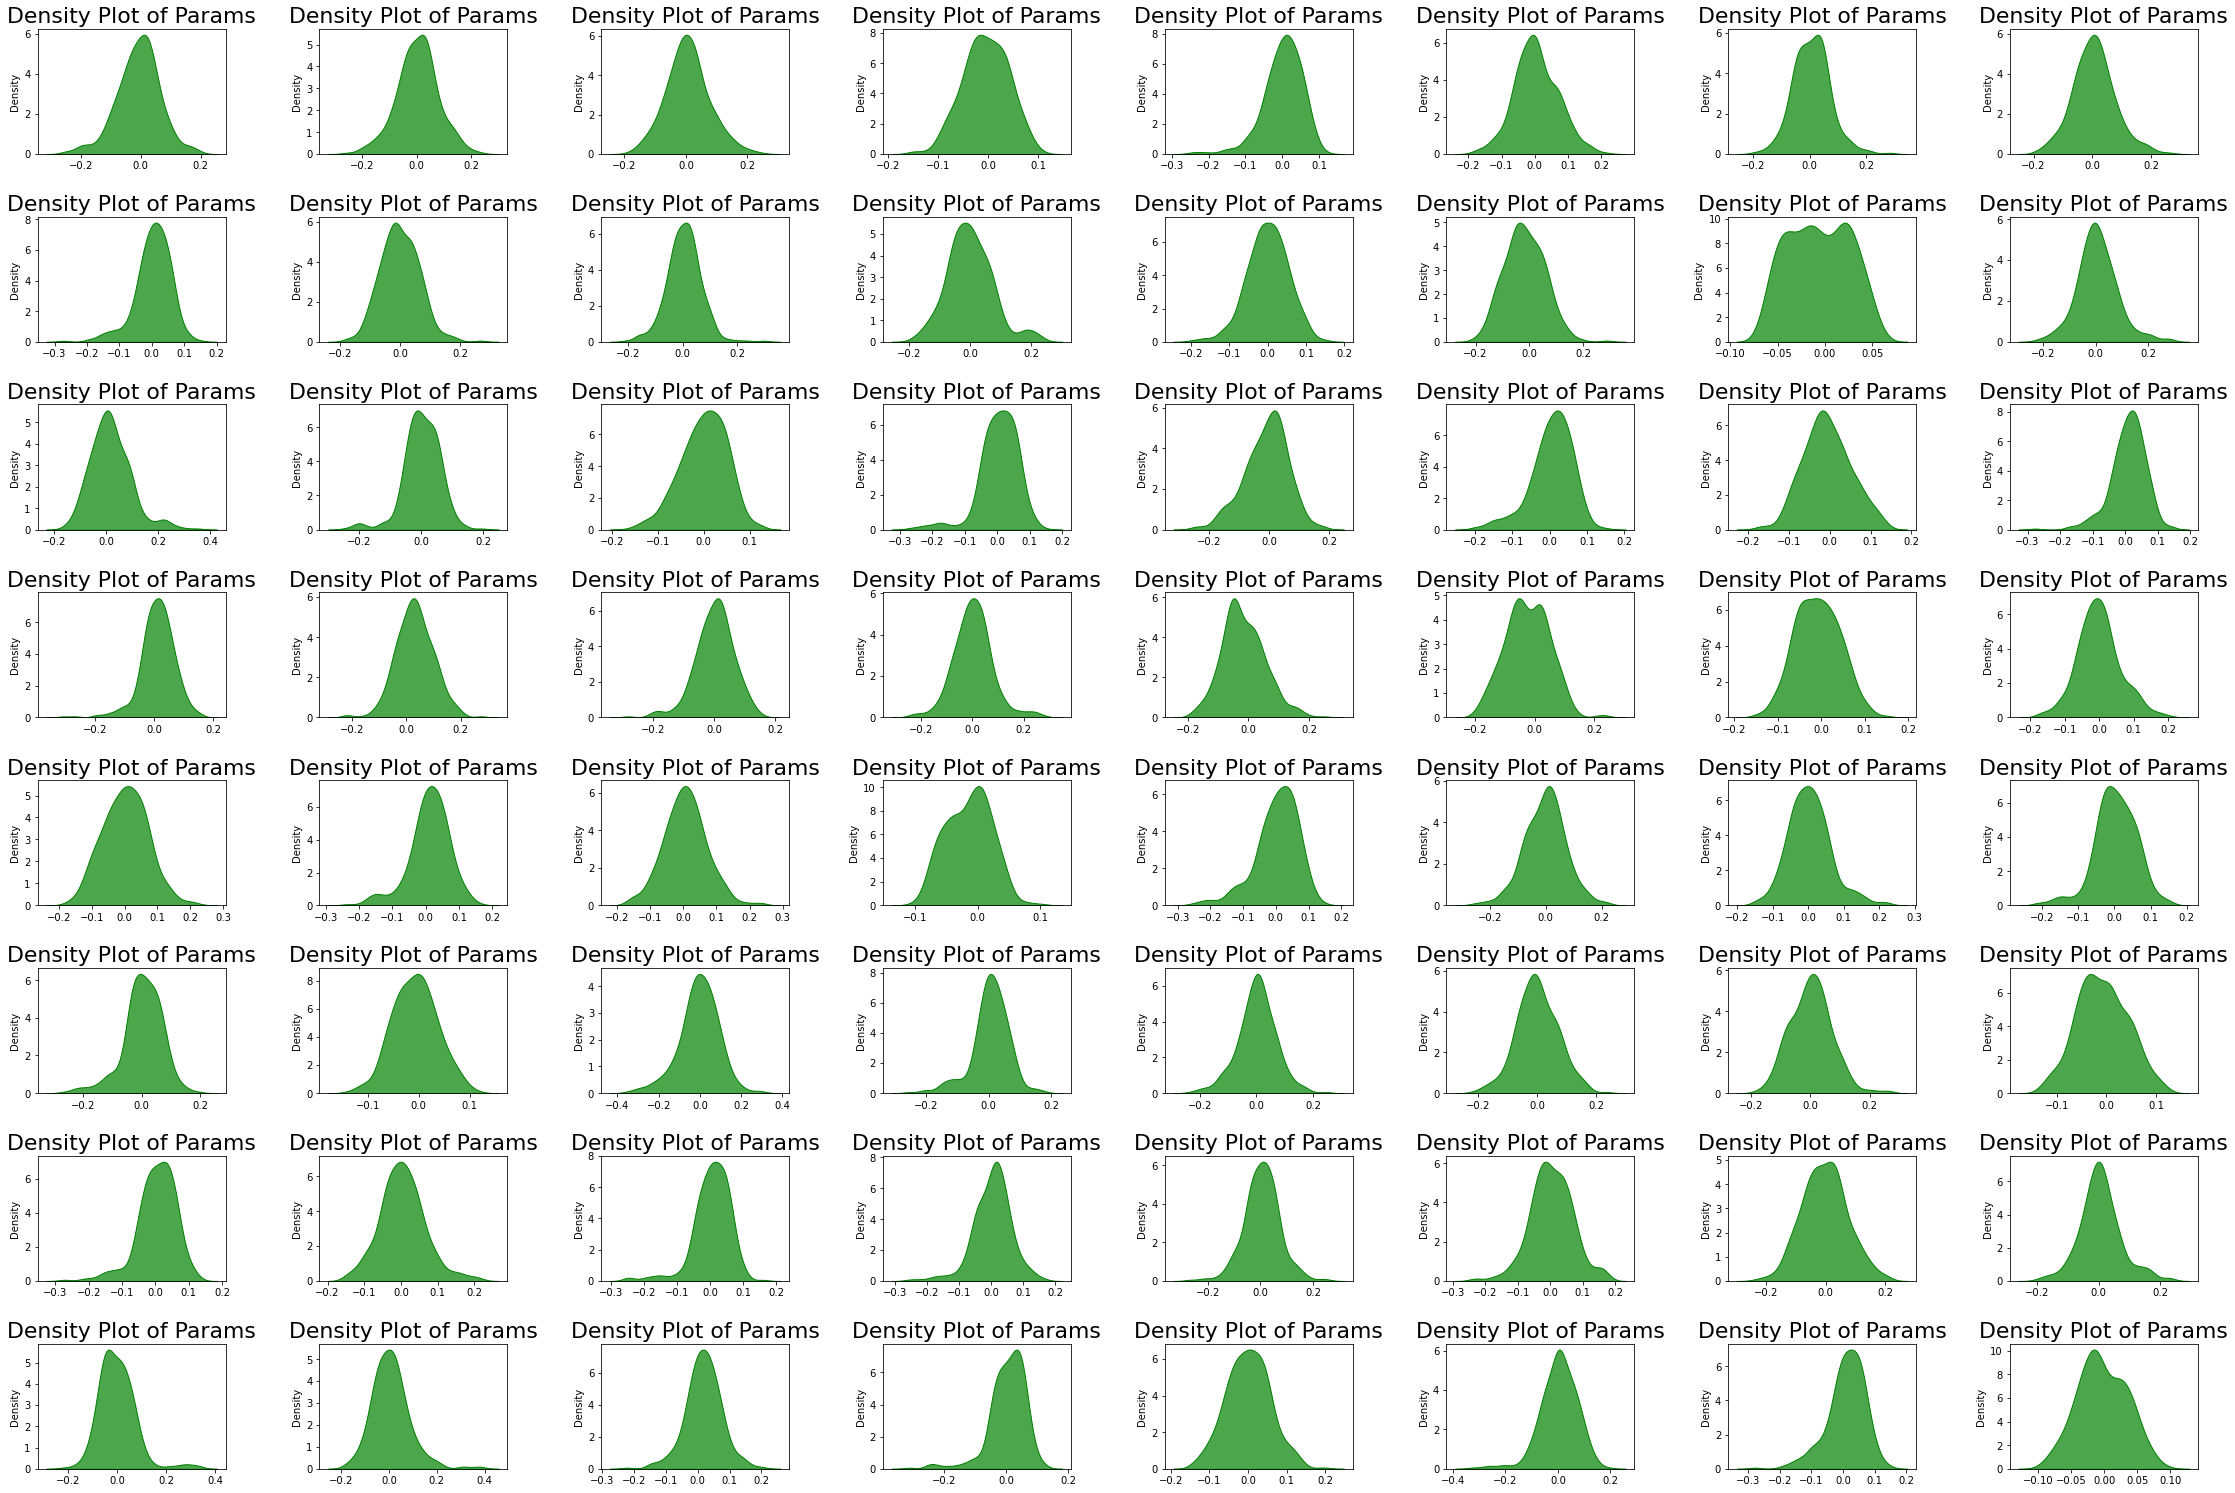

In [96]:
layer5 = model.cnn[12].weight.view((64,64*5)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(64):
    plt.subplot(8, 8, i+1)
    sns.kdeplot(layer5[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

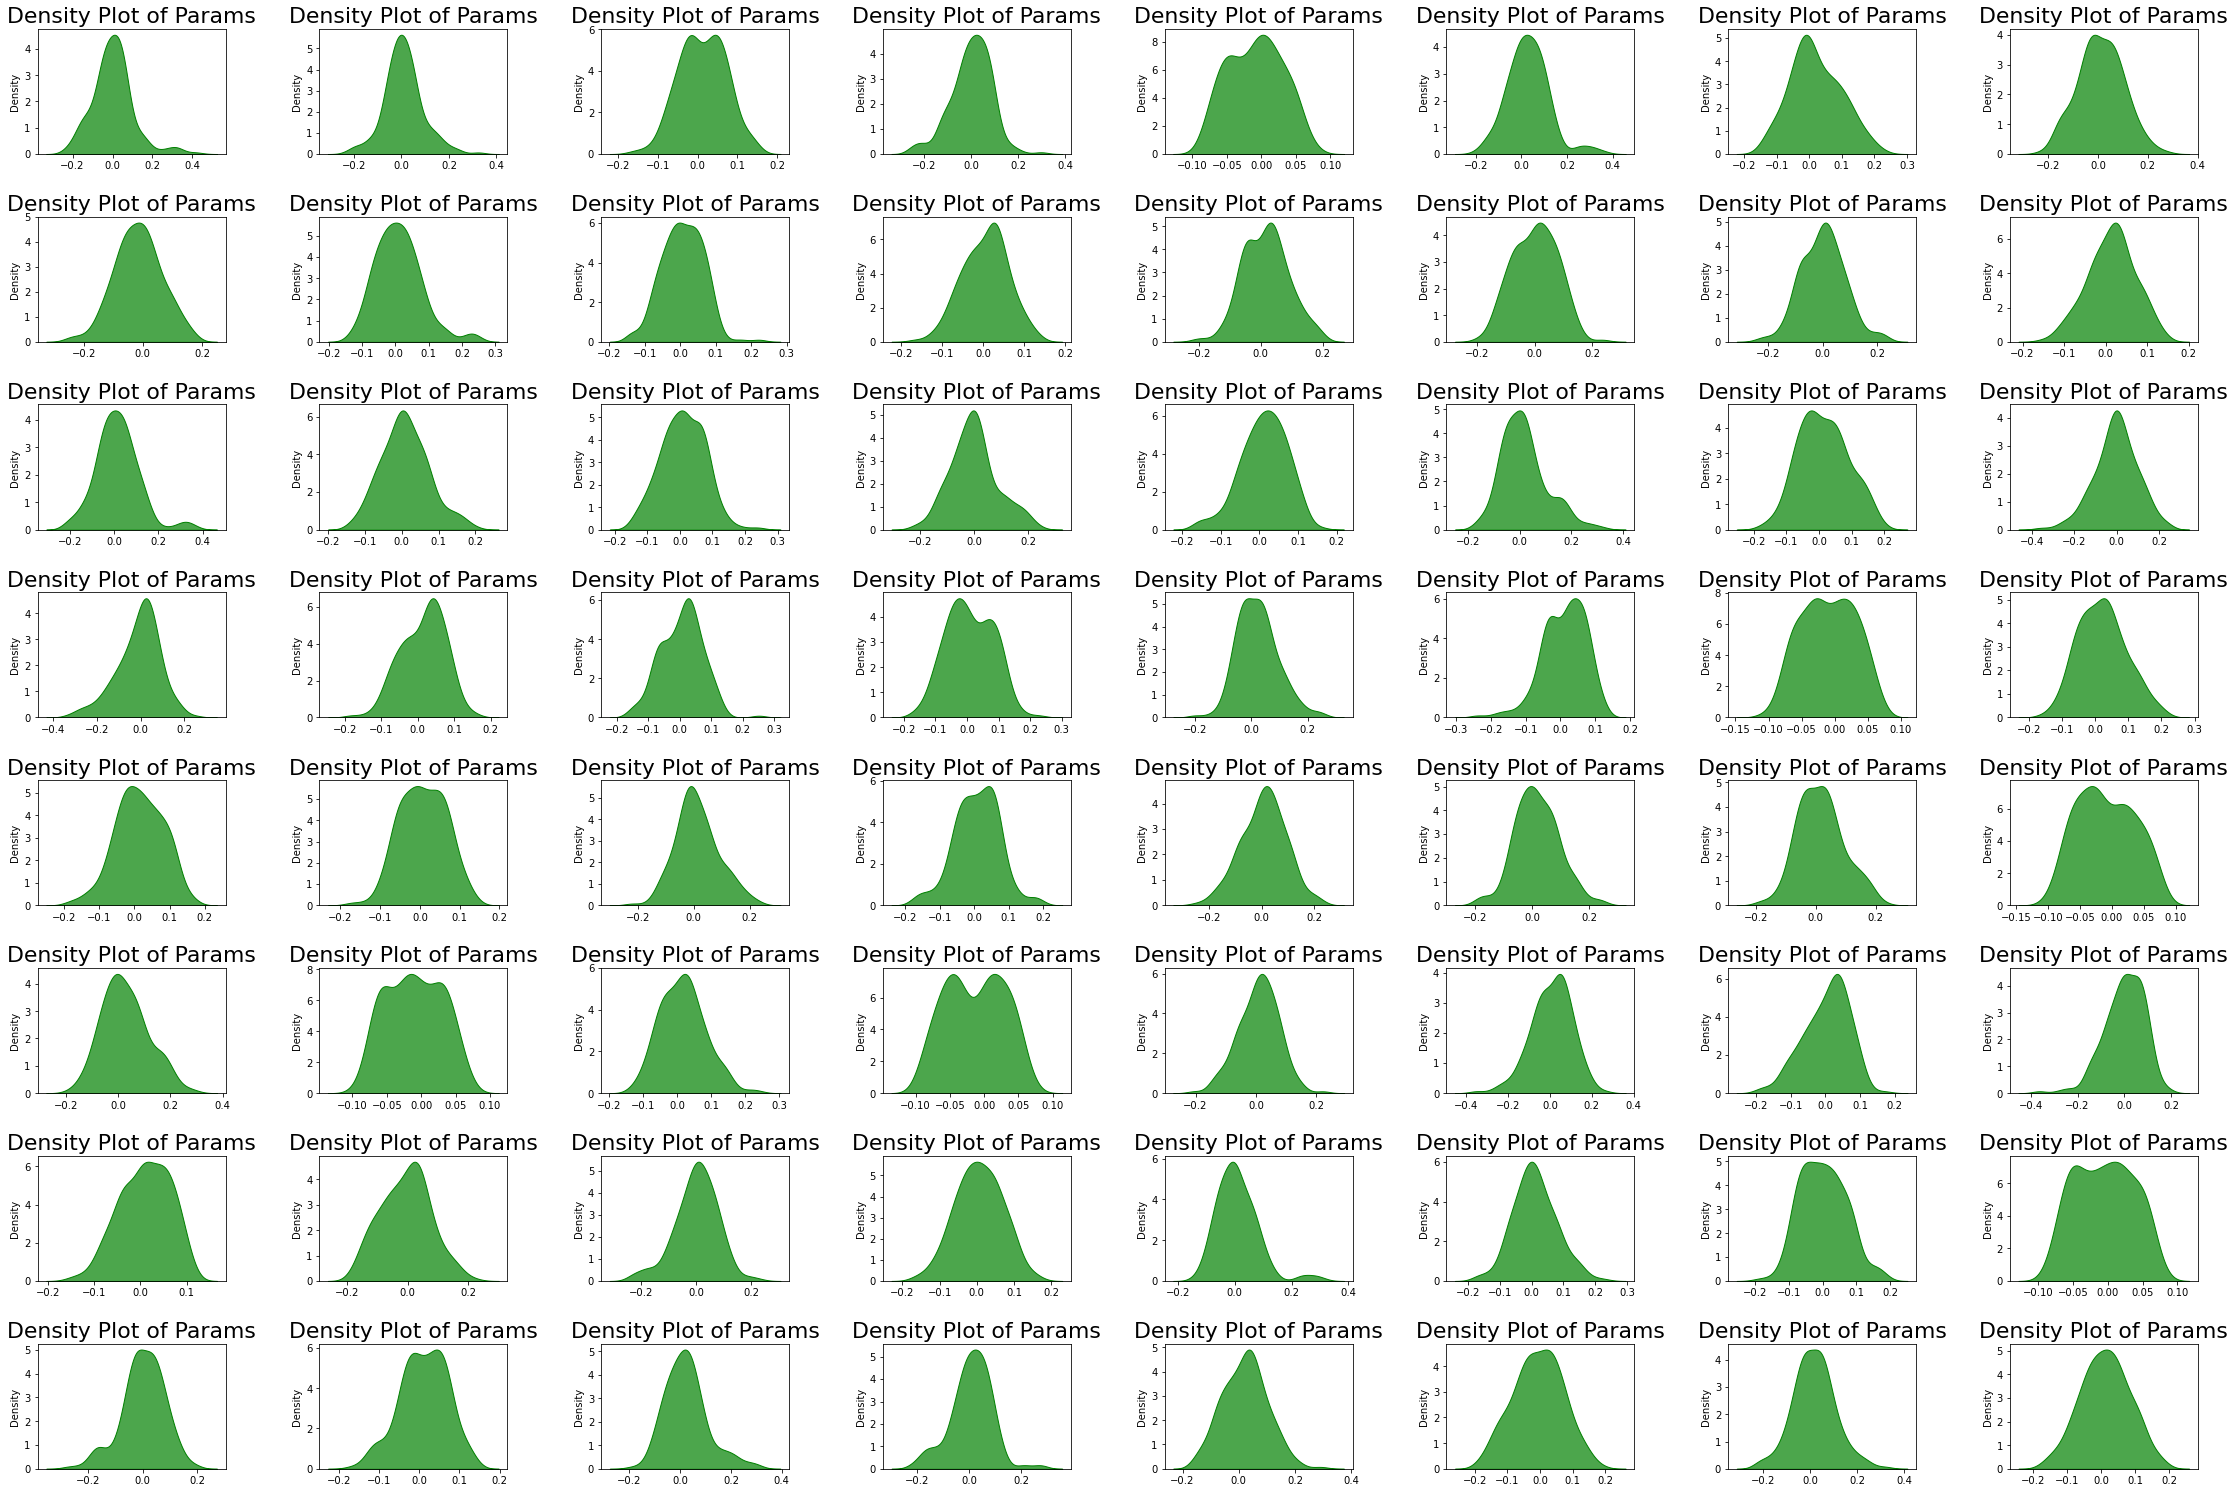

In [97]:
layer6 = model.cnn[15].weight.view((64,64*3)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(64):
    plt.subplot(8, 8, i+1)
    sns.kdeplot(layer6[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

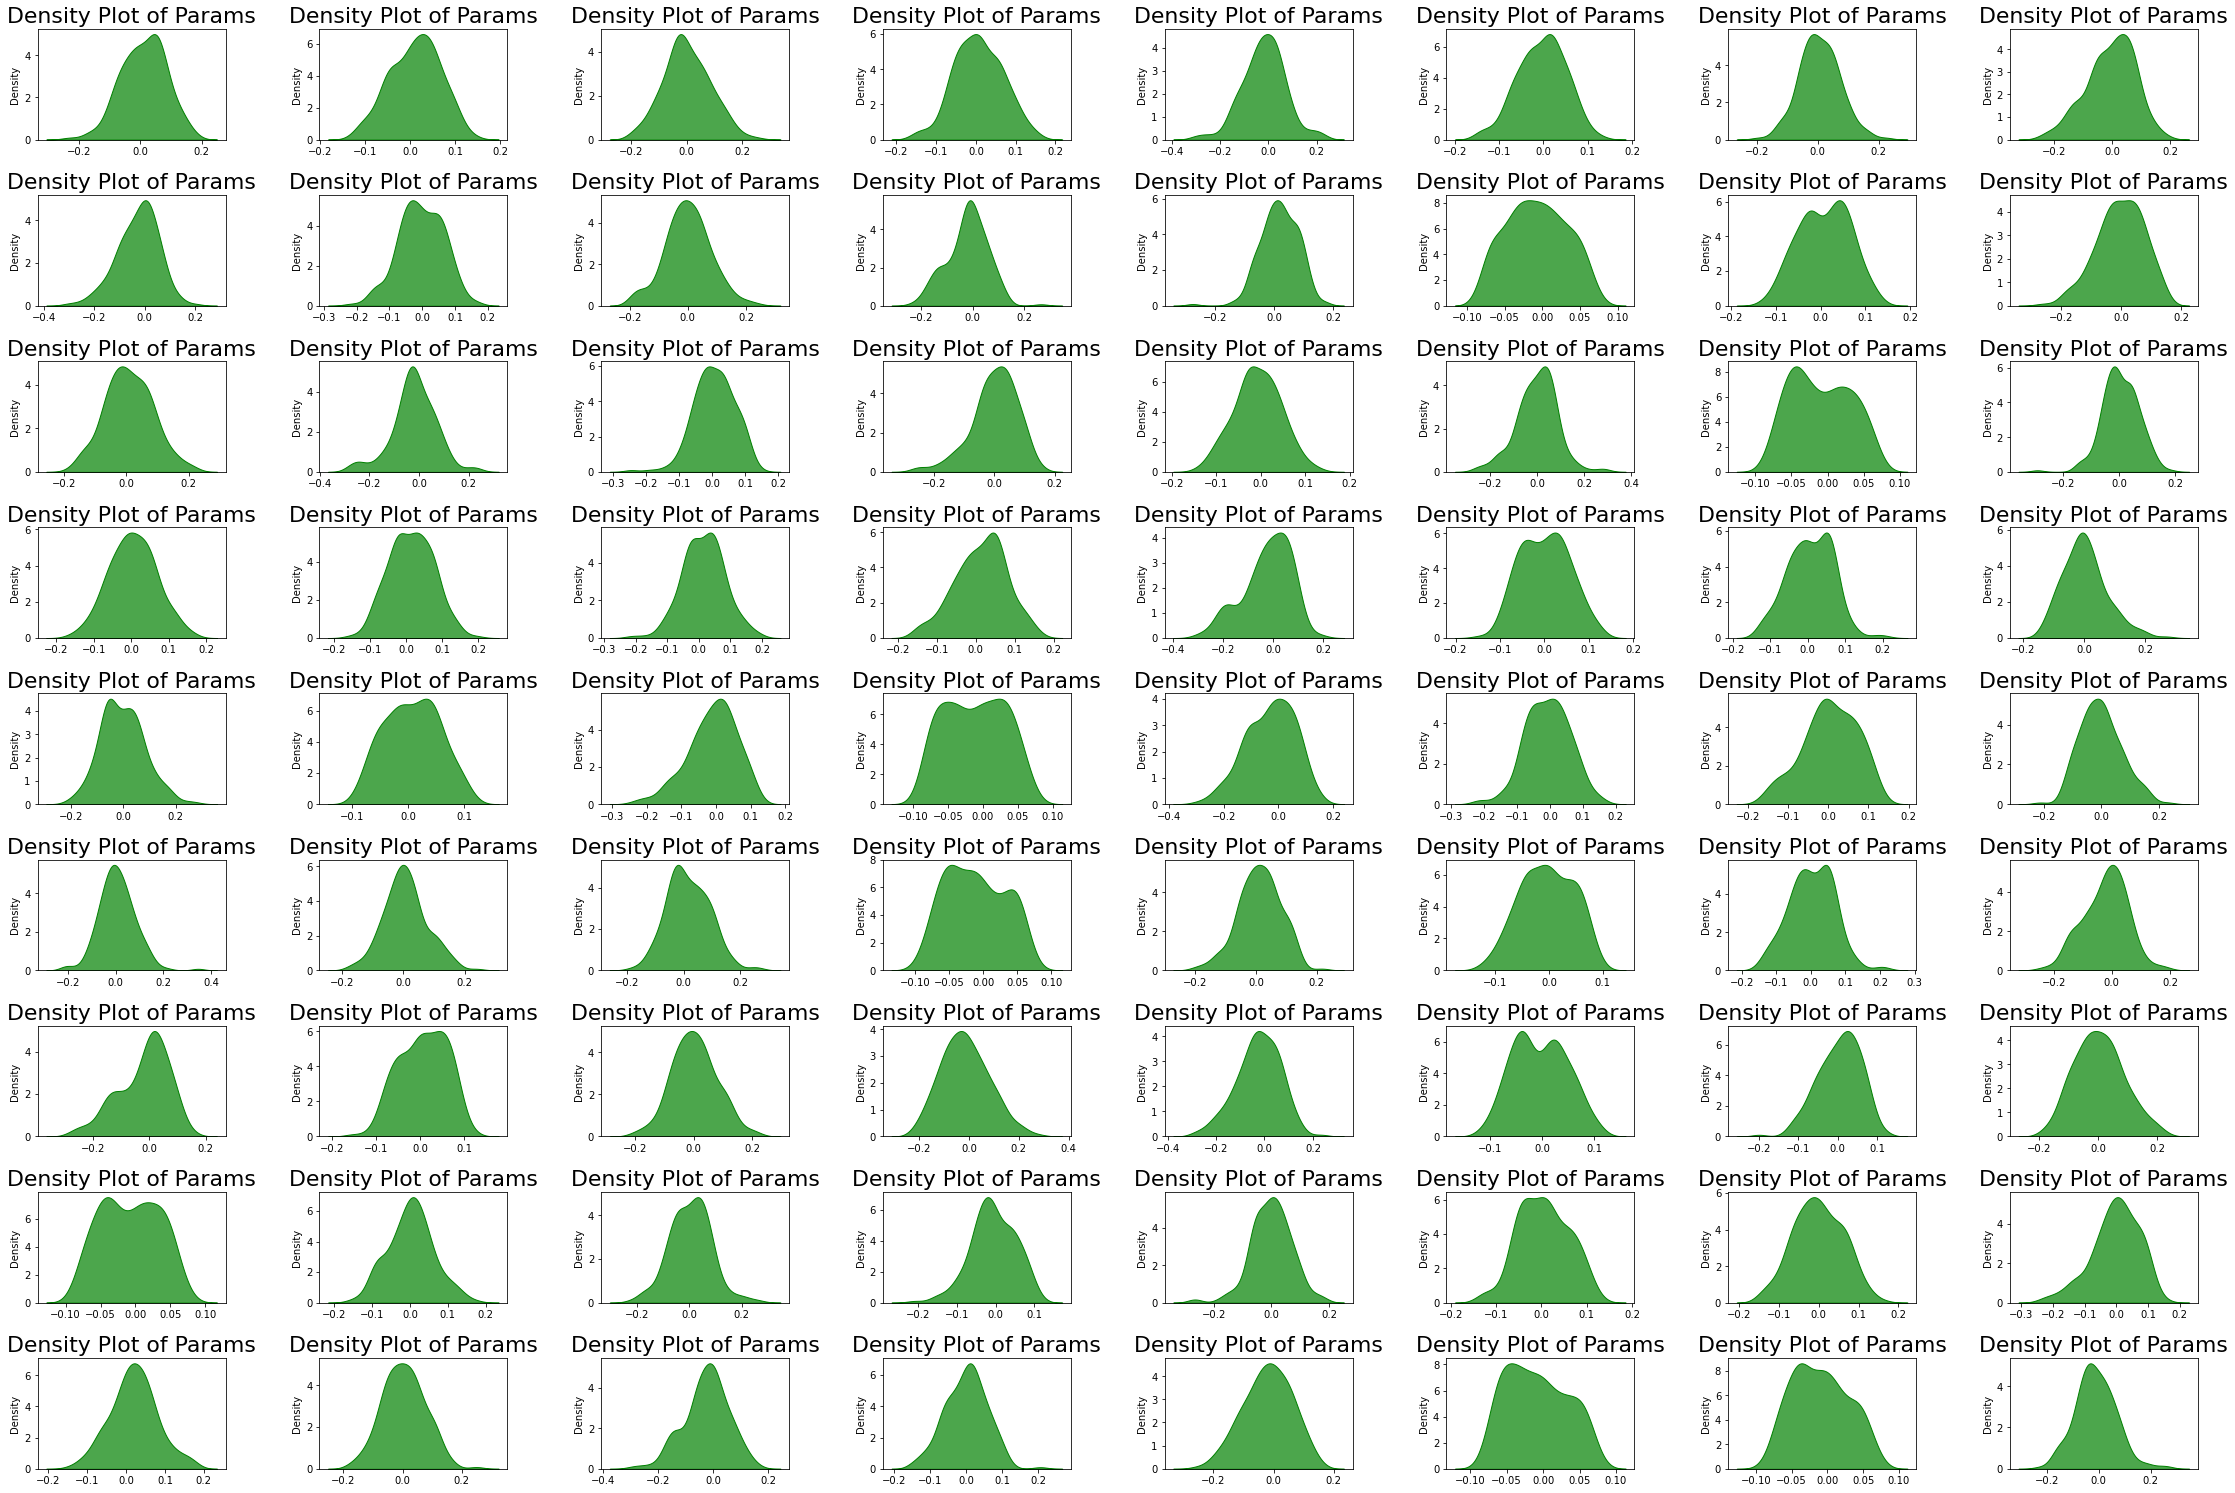

In [98]:
layer7 = model.cnn[18].weight.view((72,64*3)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(72):
    plt.subplot(9, 8, i+1)
    sns.kdeplot(layer7[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

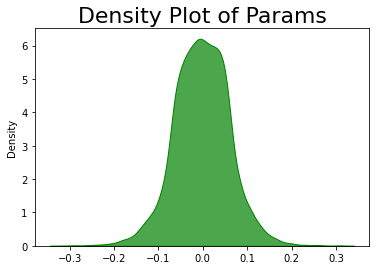

In [102]:
layer8 = model.cnn[22].weight.view((64*216)).to("cpu").detach().numpy()
for i in range(1):
    plt.subplot(1, 1, i+1)
    sns.kdeplot(layer8, shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

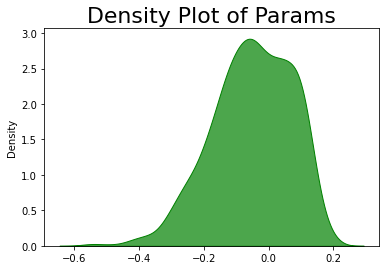

In [103]:
layer9 = model.cnn[25].weight.view((64*17)).to("cpu").detach().numpy()
for i in range(1):
    plt.subplot(1, 1, i+1)
    sns.kdeplot(layer9, shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

## Quantization

In [104]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

## extra packages
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime

from quant import *
from fold_batch_norm import *

def mystr2bool(v):
  return v.lower() in ("yes", "true", "t", "1")

## define parser
parser = argparse.ArgumentParser(description='PyTorch PWLQ code on ImageNet')
parser.add_argument('-data', default='/your/own/path/to/imagenet')
parser.add_argument('-a', '--arch', default='resnet50', help='network architecture')
parser.add_argument('-b', '--batch-size', default=128, type=int)
parser.add_argument('-p', '--print-freq', default=100, type=int)
parser.add_argument('--gpu', default=None, type=int, help='GPU id to use.')

## extras for quantization
parser.add_argument('-fbn', '--fold_bn', dest='fold_bn', action='store_true',
                    help='fold batch normalization')
parser.add_argument('-quant', '--quantize', dest='quantize', action='store_true',
                    help='quantize model')
parser.add_argument('-gs', '--get_stats', dest='get_stats', action='store_true',
                    help='get stats of activations')
parser.add_argument('-wb', '--wei_bits', '--weight-bits', default=0.0, type=float,
                    metavar='WB', help='weight quantization bits')
parser.add_argument('-ab', '--act_bits', '--activation-bits', default=0.0, type=float,
                    metavar='AB', help='activation quantization bits')
parser.add_argument('-sb', '--scale_bits', default=0.0, type=float,
                    metavar='SB', help='scale/shift quantization bits')
parser.add_argument('-wq', '--wei_quant_scheme', default='none', type=str,
                    choices=['uniform', 'pw-2', 'pw-1'],
                    help='weight quantization scheme: uniform, PWLQ')
parser.add_argument('-aq', '--act_clip_method', default='top_10', type=str,
                    help='activations clip-quantization method'
                    'choices: none, on-the-fly, clip_1.0, top_10, etc.')
parser.add_argument('-bc', '--bias_corr', default=False, type=mystr2bool,
                    help='Whether to use bias correction for weights quantization')
parser.add_argument('-appx', '--approximate', default=False, type=mystr2bool,
                    help='Whether to use approximated optimal breakpoint')
parser.add_argument('-bkp', '--break-point', default='none', type=str,
                    help='how to get optimal breakpoint: norm, laplace, search')
parser.add_argument('-sr', '--save_res', default=True, type=mystr2bool,
                    help='save results')
parser.add_argument('-cms', '--comments', default='', type=str,
                    help='make comments')

## main function
def main():
    best_acc1 = 0
    total_start_time = time.time()
    
    args = parser.parse_args()
    print(str(args))
    print()

    # use one GPU to get the activation stats 
    if args.get_stats:
        args.gpu = 0
        args.batch_size = 4

    if args.gpu is not None:
        print("Use GPU: {} for the calibration of activation ranges".format(args.gpu))

    # load pre-trained model 
    print("=> using pre-trained model '{}'".format(args.arch))
    model = models.__dict__[args.arch](pretrained=True)
    checkpoint = model.state_dict()
    print('----- pretrained model loaded -----')

    ## fold batch normalization
    if args.fold_bn:
        checkpoint, weight_layers = fold_batch_norm(checkpoint, arch=args.arch)

    # quantize weights
    rmse = 0
    if args.quantize:
        print('quantize weights ...')
        assert(args.fold_bn)
        checkpoint, rmse = quant_checkpoint(checkpoint, weight_layers, args)
    
    # load the updated weights
    model.load_state_dict(checkpoint)
    del checkpoint

    # quantize or load activation stats
    model = quant_model_acts(model, args.act_bits, args.get_stats, args.batch_size)
    if args.quantize and not args.get_stats:
        act_stats_save_path = 'stats/%s_act_stats.pth' % args.arch
        mode = load_model_act_stats(model, act_stats_save_path, args.act_clip_method)

    # use GPU
    if args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model = model.cuda(args.gpu)
    else:
        model = torch.nn.DataParallel(model).cuda()
    criterion = nn.CrossEntropyLoss().cuda(args.gpu)
    cudnn.benchmark = True

    # load data
    crop_size = 224
    scale = 0.875
    if args.arch.startswith('inception'):
        crop_size = 299
    large_crop_size = int(round(crop_size / scale))
    print('\nlarger crop size: ', large_crop_size)
    print('center crop size: ', crop_size)

    traindir = os.path.join(args.data, 'train')
    valdir = os.path.join(args.data, 'val')
    shuffle_option = False
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    if args.get_stats:
        valdir = os.path.join(args.data, 'train')
        shuffle_option = True

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(large_crop_size),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=shuffle_option,
        num_workers=8, pin_memory=True)
    
    # get activation stats on training data
    if args.get_stats:
        # calibrate the activation ranges
        validate(val_loader, model, criterion, args)

        # save the activation stats
        os.makedirs('stats/', exist_ok=True)
        act_stats_save_path = 'stats/%s_act_stats.pth' % args.arch
        save_model_act_stats(model, act_stats_save_path)

        return

    # evaluate on validation dataset
    val_start_time = time.time()
    top1_avg_acc, top5_avg_acc = validate(val_loader, model, criterion, args)
    print('\nvalidation time: %.2f min' % ((time.time() - val_start_time) / 60))

    # save accuracy results
    save_acc_res = True
    save_comments = args.comments 
    if save_acc_res:
        os.makedirs('results/', exist_ok=True)
        table_path = 'results/accuracy_results_%s.csv' % args.arch 

        new_df = pd.DataFrame({'model': [args.arch], 'quantize': [args.quantize], 
            'wei_bits': [args.wei_bits], 'wei_quant_scheme': [args.wei_quant_scheme],  
            'bias_corr': ['BC: yes' if args.bias_corr else 'BC: no'], 
            'approximate': ['appx: yes' if args.approximate else 'appx: no'], 
            'scale_bits': [args.scale_bits],
            'act_bits': [args.act_bits], 'act_clip_method': [args.act_clip_method],
            'break_point': [args.break_point], 
            'wei_quant_rmse': [rmse], 
            'top1': [float(top1_avg_acc)], 'top5': [float(top5_avg_acc)], 
            'comments': [save_comments], 
            'time': [( datetime.now().strftime('%Y-%m-%d_%H-%M-%S'), 
                '%.2f min' % ((time.time() - total_start_time)/60) )]})
        
        new_df = new_df[['model', 'quantize', 'act_bits', 'wei_bits', 'scale_bits', 'act_clip_method', 
                        'wei_quant_scheme', 'break_point', 'approximate', 'bias_corr',  
                        'wei_quant_rmse', 'top1', 'top5', 'time', 'comments']]
        
        if os.path.exists(table_path):
            old_df = pd.read_csv(table_path)
            new_df = old_df.append(new_df)
        new_df.to_csv(table_path, index = False)
        
    return


def validate(val_loader, model, criterion, args):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if args.gpu is not None:
                images = images.cuda(args.gpu, non_blocking=True)
            target = target.cuda(args.gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                progress.display(i)

            if args.get_stats and (i + 1) * args.batch_size >= 512:
                break

        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg, top5.avg


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [105]:
start_time = time.time()
main()
end_time = time.time()
print('total running time: %.2f min\n' % ((end_time - start_time) / 60))

usage: ipykernel_launcher.py [-h] [-data DATA] [-a ARCH] [-b BATCH_SIZE]
                             [-p PRINT_FREQ] [--gpu GPU] [-fbn] [-quant] [-gs]
                             [-wb WB] [-ab AB] [-sb SB]
                             [-wq {uniform,pw-2,pw-1}] [-aq ACT_CLIP_METHOD]
                             [-bc BIAS_CORR] [-appx APPROXIMATE]
                             [-bkp BREAK_POINT] [-sr SAVE_RES] [-cms COMMENTS]
ipykernel_launcher.py: error: unrecognized arguments: /home/preminstrel/.local/share/jupyter/runtime/kernel-b612b366-b456-4805-b2e2-32cea2a1e919.json


SystemExit: 2

/home/preminstrel/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [106]:
model

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(2,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 12, kernel_size=(12,), stride=(2,), padding=(5,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(12, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(

In [107]:
torch.save(model, 'test_1.pt')